# MachineLearningStocks in python: a starter project and guide

[![forthebadge made-with-python](https://ForTheBadge.com/images/badges/made-with-python.svg)](https://www.python.org/)

[![GitHub license](https://img.shields.io/badge/License-MIT-brightgreen.svg?style=flat-square)](https://github.com/surelyourejoking/MachineLearningStocks/blob/master/LICENSE.txt) [![Maintenance](https://img.shields.io/badge/Maintained%3F-yes-brightgreen.svg?style=flat-square)](https://github.com/surelyourejoking/MachineLearningStocks/graphs/commit-activity) [![PRs Welcome](https://img.shields.io/badge/PRs-welcome-brightgreen.svg?style=flat-square)](http://makeapullrequest.com)

MachineLearningStocks is designed to be an **intuitive** and **highly extensible** template project applying machine learning to making stock predictions. My hope is that this project will help you understand the overall workflow of using machine learning to predict stock movements and also appreciate some of its subtleties. And of course, after following this guide and playing around with the project, you should definitely **make your own improvements** – if you're struggling to think of what to do, at the end of this readme I've included a long list of possiblilities: take your pick.

Concretely, we will be cleaning and preparing a dataset of historical stock prices and fundamentals using `pandas`, after which we will apply a `scikit-learn` classifier to discover the relationship between stock fundamentals (e.g PE ratio, debt/equity, float, etc) and the subsequent annual price change (compared with the an index). We then conduct a simple backtest, before generating predictions on current data.

While I would not live trade based off of the predictions from this exact code, I do believe that you can use this project as starting point for a profitable trading system – I have actually used code based on this project to live trade, with pretty decent results (around 20% returns on backtest and 10-15% on live trading).

This project has quite a lot of personal significance for me. It was my first proper python project, one of my first real encounters with ML, and the first time I used git. At the start, my code was rife with bad practice and inefficiency: I have since tried to amend most of this, but please be warned that some minor issues may remain (feel free to raise an issue, or fork and submit a PR). Both the project and myself as a programmer have evolved a lot since the first iteration, but there is always room to improve.

*As a disclaimer, this is a purely educational project. Be aware that backtested performance may often be deceptive – trade at your own risk!*

*MachineLearningStocks predicts which stocks will outperform. But it does not suggest how best to combine them into a portfolio. I have just released [PyPortfolioOpt](https://github.com/robertmartin8/PyPortfolioOpt), a portfolio optimisation library which uses
classical efficient frontier techniques (with modern improvements) in order to generate risk-efficient portfolios. Generating optimal allocations from the predicted outperformers might be a great way to improve risk-adjusted returns.*

*This guide has been cross-posted at my academic blog, [reasonabledeviations.com](https://reasonabledeviations.com/)*

## Contents

- [Contents](#contents)
- [Overview](#overview)
  - [EDIT as of 24/5/18](#edit-as-of-24518)
  - [EDIT as of October 2019](#edit-as-of-october-2019)
- [Quickstart](#quickstart)
- [Preliminaries](#preliminaries)
- [Historical data](#historical-data)
  - [Historical stock fundamentals](#historical-stock-fundamentals)
  - [Historical price data](#historical-price-data)
- [Creating the training dataset](#creating-the-training-dataset)
  - [Preprocessing historical price data](#preprocessing-historical-price-data)
  - [Features](#features)
    - [Valuation measures](#valuation-measures)
    - [Financials](#financials)
    - [Trading information](#trading-information)
  - [Parsing](#parsing)
- [Backtesting](#backtesting)
- [Current fundamental data](#current-fundamental-data)
- [Stock prediction](#stock-prediction)
- [Unit testing](#unit-testing)
- [Where to go from here](#where-to-go-from-here)
  - [Data acquisition](#data-acquisition)
  - [Data preprocessing](#data-preprocessing)
  - [Machine learning](#machine-learning)
- [Contributing](#contributing)

## Overview

The overall workflow to use machine learning to make stocks prediction is as follows:

1. Acquire historical fundamental data – these are the *features* or *predictors*
2. Acquire historical stock price data – this is will make up the dependent variable, or label (what we are trying to predict).
3. Preprocess data
4. Use a machine learning model to learn from the data
5. Backtest the performance of the machine learning model
6. Acquire current fundamental data
7. Generate predictions from current fundamental data

This is a very generalised overview, but in principle this is all you need to build a fundamentals-based ML stock predictor.

## Quickstart

If you want to throw away the instruction manual and play immediately, clone this project, then download and unzip the [data file](https://pythonprogramming.net/data-acquisition-machine-learning/) into the same directory. Then, open an instance of terminal and cd to the project's file path, e.g

```bash
cd Users/User/Desktop/MachineLearningStocks
```

Then, run the following in terminal:

```bash
python backtesting.py
python current_data.py
pytest -v
python stock_prediction.py
```

Otherwise, follow the step-by-step guide below.

## Preliminaries

This project uses python 3.6, and the common data science libraries `pandas` and `scikit-learn`. If you are on python 3.x less than 3.6, you will find some syntax errors wherever f-strings have been used for string formatting. These are fortunately very easy to fix (just rebuild the string using your preferred method), but I do encourage you to upgrade to 3.6 to enjoy the elegance of f-strings. A full list of requirements is included in the `requirements.txt` file. To install all of the requirements at once, run the following code in terminal:

To get started, clone this project and unzip it. This folder will become our working directory, so make sure you `cd` your terminal instance into this directory.

## Historical data

Data acquisition and preprocessing is probably the hardest part of most machine learning projects. But it is a necessary evil, so it's best to not fret and just carry on.

For this project, we need three datasets:

1. Historical stock fundamentals
2. Historical stock prices
3. Historical S&P500 prices

We need the S&P500 index prices as a benchmark: a 5% stock growth does not mean much if the S&P500 grew 10% in that time period, so all stock returns must be compared to those of the index.

### Historical stock fundamentals

Historical fundamental data is actually very difficult to find (for free, at least). Although sites like [Quandl](https://www.quandl.com/) do have datasets available, you often have to pay a pretty steep fee.

It turns out that there is a way to parse this data, for free, from [Yahoo Finance](https://finance.yahoo.com/). I will not go into details, because [Sentdex has done it for us](https://pythonprogramming.net/data-acquisition-machine-learning/). On his page you will be able to find a file called `intraQuarter.zip`, which you should download, unzip, and place in your working directory. Relevant to this project is the subfolder called `_KeyStats`, which contains html files that hold stock fundamentals for all stocks in the S&P500 between 2003 and 2013, sorted by stock. However, at this stage, the data is unusable – we will have to parse it into a nice csv file before we can do any ML.

### Historical price data

In the first iteration of the project, I used `pandas-datareader`, an extremely convenient library which can load stock data straight into `pandas`. However, after Yahoo Finance changed their UI, `datareader` no longer worked, so I switched to [Quandl](https://www.quandl.com/), which has free stock price data for a few tickers, and a python API. However, as `pandas-datareader` has been [fixed](https://github.com/ranaroussi/fix-yahoo-finance), we will use that instead.

Likewise, we can easily use `pandas-datareader` to access data for the SPY ticker. Failing that, one could manually download it from [yahoo finance](https://finance.yahoo.com/quote/%5EGSPC/history?p=%5EGSPC), place it into the project directory and rename it `sp500_index.csv`.

The code for downloading historical price data can be run by entering the following into terminal:

```bash
python download_historical_prices.py
```

## Creating the training dataset

Our ultimate goal for the training data is to have a 'snapshot' of a particular stock's fundamentals at a particular time, and the corresponding subsequent annual performance of the stock.

For example, if our 'snapshot' consists of all of the fundamental data for AAPL on the date 28/1/2005, then we also need to know the percentage price change of AAPL between 28/1/05 and 28/1/06. Thus our algorithm can learn how the fundamentals impact the annual change in the stock price.

In fact, this is a slight oversimplification. In fact, what the algorithm will eventually learn is how fundamentals impact the *outperformance of a stock relative to the S&P500 index*. This is why we also need index data.

### Preprocessing historical price data

When `pandas-datareader` downloads stock price data, it does not include rows for weekends and public holidays (when the market is closed).

However, referring to the example of AAPL above, if our snapshot includes fundamental data for 28/1/05 and we want to see the change in price a year later, we will get the nasty surprise that 28/1/2006 is a Saturday. Does this mean that we have to discard this snapshot?

By no means – data is too valuable to callously toss away. As a workaround, I instead decided to 'fill forward' the missing data, i.e we will assume that the stock price on Saturday 28/1/2006 is equal to the stock price on Friday 27/1/2006.

### Features

Below is a list of some of the interesting variables that are available on Yahoo Finance.

#### Valuation measures

- 'Market Cap'
- Enterprise Value
- Trailing P/E
- Forward P/E
- PEG Ratio
- Price/Sales
- Price/Book
- Enterprise Value/Revenue
- Enterprise Value/EBITDA

#### Financials

- Profit Margin
- Operating Margin
- Return on Assets
- Return on Equity
- Revenue
- Revenue Per Share
- Quarterly Revenue Growth
- Gross Profit
- EBITDA
- Net Income Avi to Common
- Diluted EPS
- Quarterly Earnings Growth
- Total Cash
- Total Cash Per Share
- Total Debt
- Total Debt/Equity
- Current Ratio
- Book Value Per Share
- Operating Cash Flow
- Levered Free Cash Flow

#### Trading information

- Beta
- 50-Day Moving Average
- 200-Day Moving Average
- Avg Vol (3 month)
- Shares Outstanding
- Float
- % Held by Insiders
- % Held by Institutions
- Shares Short
- Short Ratio
- Short % of Float
- Shares Short (prior month)

### Parsing

However, all of this data is locked up in HTML files. Thus, we need to build a parser. In this project, I did the parsing with regex, but please note that generally it is [really not recommended](https://stackoverflow.com/questions/1732348/regex-match-open-tags-except-xhtml-self-contained-tags) to use regex to parse HTML. However, I think regex probably wins out for ease of understanding (this project being educational in nature), and from experience regex works fine in this case.

This is the exact regex used:

```python
r'>' + re.escape(variable) + r'.*?(\-?\d+\.*\d*K?M?B?|N/A[\\n|\s]*|>0|NaN)%?(</td>|</span>)'
```

While it looks pretty arcane, all it is doing is searching for the first occurence of the feature (e.g "Market Cap"), then it looks forward until it finds a number immediately followed by a `</td>` or `</span>` (signifying the end of a table entry). The complexity of the expression above accounts for some subtleties in the parsing:

- the numbers could be preceeded by a minus sign
- Yahoo Finance sometimes uses K, M, and B as abbreviations for thousand, million and billion respectively.
- some data are given as percentages
- some datapoints are missing, so instead of a number we have to look for "N/A" or "NaN.

Both the preprocessing of price data and the parsing of keystats are included in `parsing_keystats.py`. Run the following in your terminal:

```bash
python parsing_keystats.py
```

You should see the file `keystats.csv` appear in your working directory. Now that we have the training data ready, we are ready to actually do some machine learning.

## Current fundamental data

Now that we have trained and backtested a model on our data, we would like to generate actual predictions on current data.

As always, we can scrape the data from good old Yahoo Finance. My method is to literally just download the statistics page for each stock (here is the [page](https://finance.yahoo.com/quote/AAPL/key-statistics?p=AAPL) for Apple), then to parse it using regex as before.

In fact, the regex should be almost identical, but because Yahoo has changed their UI a couple of times, there are some minor differences. This part of the projet has to be fixed whenever yahoo finance changes their UI, so if you can't get the project to work, the problem is most likely here.

Run the following in terminal:

```bash
python current_data.py
```

The script will then begin downloading the HTML into the `forward/` folder within your working directory, before parsing this data and outputting the file `forward_sample.csv`. You might see a few miscellaneous errors for certain tickers (e.g 'Exceeded 30 redirects.'), but this is to be expected.

## Stock prediction

Now that we have the training data and the current data, we can finally generate actual predictions. This part of the project is very simple: the only thing you have to decide is the value of the `OUTPERFORMANCE` parameter (the percentage by which a stock has to beat the S&P500 to be considered a 'buy'). I have set it to 10 by default, but it can easily be modified by changing the variable at the top of the file. Go ahead and run the script:

```bash
python stock_prediction.py
```

You should get something like this:

```txt
21 stocks predicted to outperform the S&P500 by more than 10%:
NOC FL SWK NFX LH NSC SCHL KSU DDS GWW AIZ ORLY R SFLY SHW GME DLX DIS AMP BBBY APD
```

## Unit testing

I have included a number of unit tests (in the `tests/` folder) which serve to check that things are working properly. However, due to the nature of the some of this projects functionality (downloading big datasets), you will have to run all the code once before running the tests. Otherwise, the tests themselves would have to download huge datasets (which I don't think is optimal).

I thus recommend that you run the tests after you have run all the other scripts (except, perhaps, `stock_prediction.py`).

To run the tests, simply enter the following into a terminal instance in the project directory:

```bash
pytest -v
```

Please note that it is not considered best practice to include an `__init__.py` file in the `tests/` directory (see [here](https://docs.pytest.org/en/latest/goodpractices.html) for more), but I have done it anyway because it is uncomplicated and functional.

## Where to go from here

I have stated that this project is extensible, so here are some ideas to get you started and possibly increase returns (no promises).

### Data acquisition

My personal belief is that better quality data is THE factor that will ultimately determine your performance. Here are some ideas:

- Explore the other subfolders in Sentdex's `intraQuarter.zip`.
- Parse the annual reports that all companies submit to the SEC (have a look at the [Edgar Database](https://www.sec.gov/edgar/searchedgar/companysearch.html))
- Try to find websites from which you can scrape fundamental data (this has been my solution).
- Ditch US stocks and go global – perhaps better results may be found in markets that are less-liquid. It'd be interesting to see whether the predictive power of features vary based on geography.
- Buy Quandl data, or experiment with alternative data.

### Data preprocessing

- Build a more robust parser using BeautifulSoup
- In this project, I have just ignored any rows with missing data, but this reduces the size of the dataset considerably. Are there any ways you can fill in some of this data?
  - hint: if the PE ratio is missing but you know the stock price and the earnings/share...
  - hint 2: how different is Apple's book value in March to its book value in June?
- Some form of feature engineering
  - e.g, calculate [Graham's number](https://www.investopedia.com/terms/g/graham-number.asp) and use it as a feature
  - some of the features are probably redundant. Why not remove them to speed up training?
- Speed up the construction of `keystats.csv`.
  - hint: don't keep appending to one growing dataframe! Split it into chunks

### Machine learning

Altering the machine learning stuff is probably the easiest and most fun to do.

- The most important thing if you're serious about results is to find the problem with the current backtesting setup and fix it. This will likely be quite a sobering experience, but if your backtest is done right, it should mean that any observed outperformance on your test set can be traded on (again, do so at your own discretion).
- Try a different classifier – there is plenty of research that advocates the use of SVMs, for example. Don't forget that other classifiers may require feature scaling etc.
- Hyperparameter tuning: use gridsearch to find the optimal hyperparameters for your classifier. But make sure you don't overfit!
- Make it *deep* – experiment with neural networks (an easy way to start is with `sklearn.neural_network`).
- Change the classification problem into a regression one: will we achieve better results if we try to predict the stock *return* rather than whether it outperformed?
- Run the prediction multiple times (perhaps using different hyperparameters?) and select the *k* most common stocks to invest in. This is especially important if the algorithm is not deterministic (as is the case for Random Forest)
- Experiment with different values of the `outperformance` parameter.
- Should we really be trying to predict raw returns? What happens if a stock achieves a 20% return but does so by being highly volatile?
- Try to plot the importance of different features to 'see what the machine sees'.



In [248]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from utils import data_string_to_float, status_calc
%matplotlib inline
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

In [249]:
# The percentage by which a stock has to beat the S&P500 to be considered a 'buy'
OUTPERFORMANCE = 5

In [250]:
"""
Reads the keystats.csv file and prepares it for scikit-learn
:return: X_train and y_train numpy arrays
"""
read_data = pd.read_csv("keystats.csv", index_col="Date")

training_data=read_data.sort_values(by='Date')

#training_data=read_data
training_data.dropna(axis=0, how="any", inplace=True)

training_data.head()
print((training_data.columns))
#print(training_data.count())

Index(['Unix', 'Ticker', 'Price', 'stock_p_change', 'SP500', 'SP500_p_change',
       'Market Cap', 'Enterprise Value', 'Trailing P/E', 'Forward P/E',
       'PEG Ratio', 'Price/Sales', 'Price/Book', 'Enterprise Value/Revenue',
       'Enterprise Value/EBITDA', 'Profit Margin', 'Operating Margin',
       'Return on Assets', 'Return on Equity', 'Revenue', 'Revenue Per Share',
       'Qtrly Revenue Growth', 'Gross Profit', 'EBITDA',
       'Net Income Avl to Common', 'Diluted EPS', 'Qtrly Earnings Growth',
       'Total Cash', 'Total Cash Per Share', 'Total Debt', 'Total Debt/Equity',
       'Current Ratio', 'Book Value Per Share', 'Operating Cash Flow',
       'Levered Free Cash Flow', 'Beta', '50-Day Moving Average',
       '200-Day Moving Average', 'Avg Vol (3 month)', 'Shares Outstanding',
       'Float', '% Held by Insiders', '% Held by Institutions',
       'Shares Short (as of', 'Short Ratio', 'Short % of Float',
       'Shares Short (prior month)'],
      dtype='object')


In [251]:
training_data.iloc[:, 0:5]

Unix Ticker      Price  stock_p_change  \
Date                                                                  
2006-03-31 08:49:22  1.143766e+09    emn  15.586985           31.86   
2006-03-31 08:49:38  1.143766e+09    lll  64.262268            3.05   
2006-03-31 23:16:48  1.143818e+09    gci  36.993389           -4.02   
2006-03-31 23:17:08  1.143818e+09    rrc  26.328451           22.75   
2006-04-06 07:18:49  1.144279e+09   ebay  16.329966          -13.12   
...                           ...    ...        ...             ...   
2013-09-03 05:46:30  1.378158e+09    jnj  76.386230           23.45   
2013-09-03 23:47:25  1.378223e+09   orcl  30.009792           32.53   
2013-09-05 17:16:45  1.378373e+09    nke  30.181412           28.63   
2013-09-06 01:19:11  1.378402e+09     vz  37.732414           12.60   
2013-09-06 06:09:52  1.378419e+09      a  32.449276           23.26   

                          SP500  
Date                             
2006-03-31 08:49:22  101.952477  
2006-03-31 08:49:38  101.952477  
2006-03-31 23:16:48  101.952477  
2006-03-31 23:17:08  101.952477  
2006-04-06 07:18:49  102.769180  
...                         ...  
2013-09-03 05:46:30  150.157349  
2013-09-03 23:47:25  150.157349  
2013-09-05 17:16:45  151.591415  
2013-09-06 01:19:11  151.664505  
2013-09-06 06:09:52  151.664505  

[3384 rows x 5 columns]

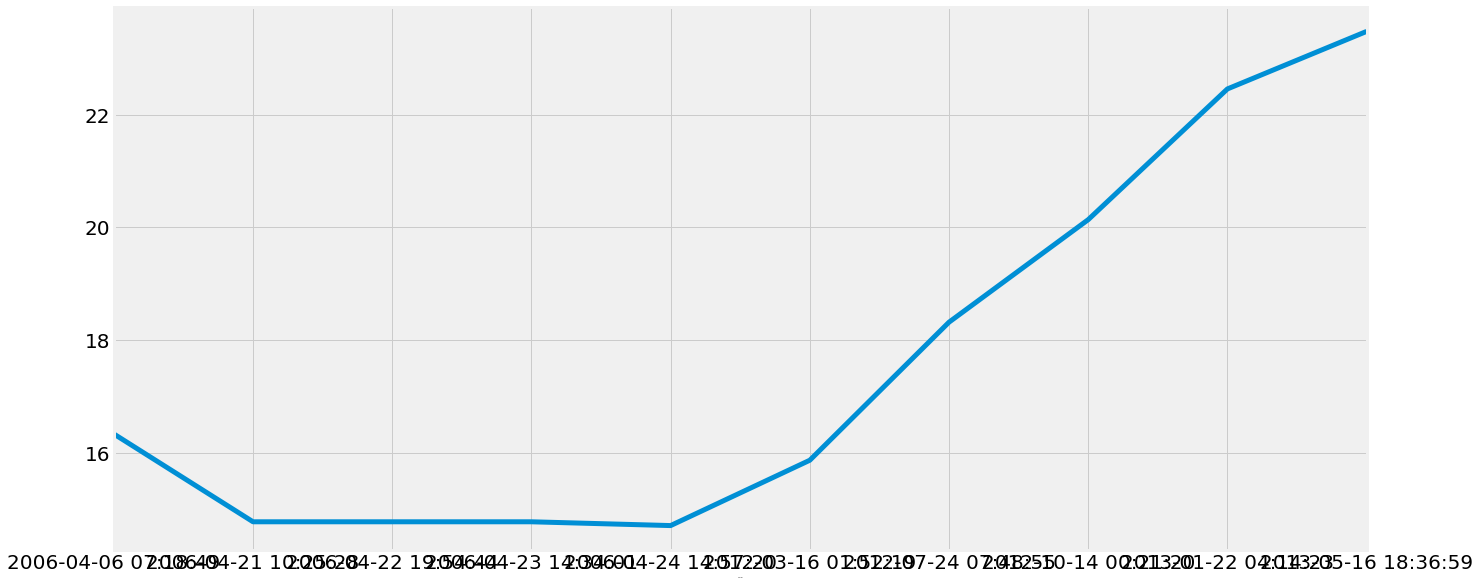

In [252]:
# Plot Ebay Tick Data 
import matplotlib.pyplot as plt

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.cbook as cbook


years = mdates.YearLocator()   # every year
months = mdates.MonthLocator()  # every month
years_fmt = mdates.DateFormatter('%Y')

ebay = training_data[training_data['Ticker']=='ebay'].sort_values(by='Date')

# Get the SPX time series. This now returns a Pandas Series object indexed by date.# Get t 
ebay_index = ebay.loc[:, 'Price']

ebay_index.plot(figsize=(20,10), linewidth=5, fontsize=20)
plt.xlabel('Year', fontsize=2);

In [253]:
ebay_index

Date
2006-04-06 07:18:49    16.329966
2006-04-21 10:25:28    14.768518
2006-04-22 19:54:44    14.768518
2006-04-23 14:34:01    14.768518
2006-04-24 14:57:20    14.701179
2012-03-16 01:52:19    15.862795
2012-07-24 07:48:55    18.316498
2012-10-14 00:21:20    20.138889
2013-01-22 04:14:23    22.462122
2013-05-16 18:36:59    23.484848
Name: Price, dtype: float64

In [254]:
features = training_data.columns[6:]

X_Independent = training_data[features].values
    # Generate the labels: '1' if a stock beats the S&P500 by more than 10%, else '0'.
y_target = list(
        status_calc(
            training_data["stock_p_change"],
            training_data["SP500_p_change"],
            OUTPERFORMANCE,
        )
)

y_target = np.asarray(y_target)

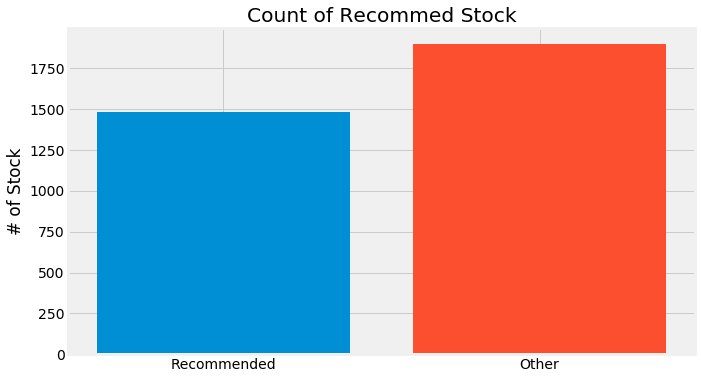

In [255]:
# Separating each class into respective DataFrames
RecommendedStock = X_Independent[y_target==True]
OtherPerformer = X_Independent[y_target==False]

RecommendedStock.shape

plt.figure(figsize=(10,6))
plt.style.use('fivethirtyeight')

# Plotting the count of each DataFrame of each class
plt.bar("Recommended", RecommendedStock.shape[0])
plt.bar("Other", OtherPerformer.shape[0])


plt.ylabel("# of Stock")
plt.title('Count of Recommed Stock')
plt.show()

In [263]:
#help(train_test_split)
# When we split the date, we must keep the order of the data and only use the old data to train the model and 
# use the new data to train and validate the model. 
X_train, X_test, y_train, y_test = train_test_split(X_Independent, y_target, shuffle=False)

#X_train, X_test, y_train, y_test = train_test_split(X_Independent, y_target)
#X_train, y_train = shuffle(X_train, y_train)

In [264]:
# Remove the random_state parameter to generate actual predictions
clf = RandomForestClassifier(n_estimators=100, random_state=0)
clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [265]:
print(X_train.shape)
print(y_train.shape)
print(X_Independent.shape)
print(X_test.shape)
print(y_test.shape)

(2538, 41)
(2538,)
(3384, 41)
(846, 41)
(846,)


41


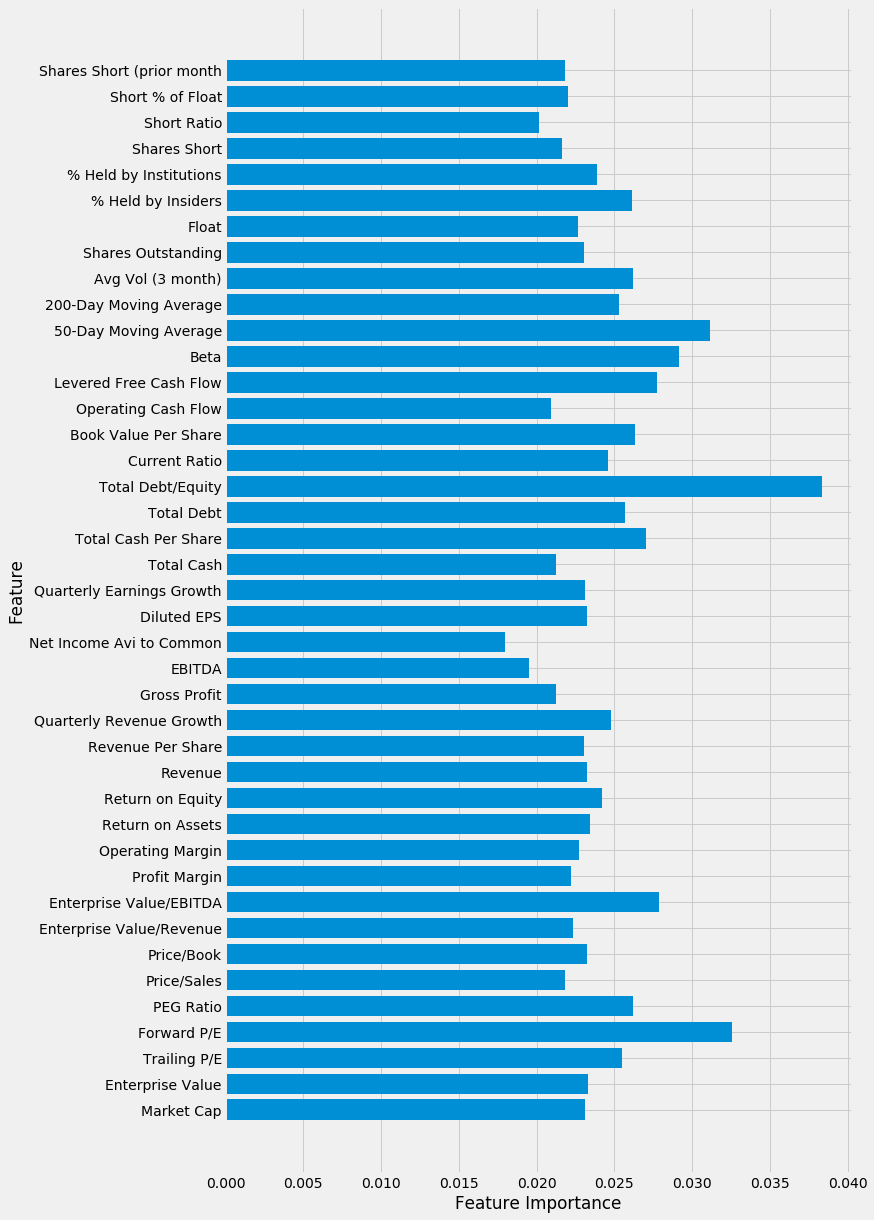

In [266]:
#Feature Importance
n_feature = X_train.shape[1]
print(n_feature)
plt.figure(figsize=(10,20))
plt.barh(range(n_feature), clf.feature_importances_, align='center')
plt.yticks(np.arange(n_feature), features)
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.show()


## Backtesting

Backtesting is arguably the most important part of any quantitative strategy: you must have some way of testing the performance of your algorithm before you live trade it.

Despite its importance, I originally did not want to include backtesting code in this repository. The reasons were as follows:

- Backtesting is messy and empirical. The code is not very pleasant to use, and in practice requires a lot of manual interaction.
- Backtesting is very difficult to get right, and if you do it wrong, you will be deceiving yourself with high returns.
- Developing and working with your backtest is probably the best way to learn about machine learning and stocks – you'll see what works, what doesn't, and what you don't understand.

Nevertheless, because of the importance of backtesting, I decided that I can't really call this a 'template machine learning stocks project' without backtesting. Thus, I have included a simplistic backtesting script. Please note that there is a fatal flaw with this backtesting implementation that will result in *much* higher backtesting returns. It is quite a subtle point, but I will let you figure that out :)

Run the following in terminal:

```bash
python backtesting.py
```

You should see the backtest between your model and S&P 500 performance comparison

```

Again, the performance looks too good to be true and almost certainly is.


In [267]:
print('acc on train dataset: {:.3f}'.format(clf.score(X_train,y_train)))
print('acc on test dataset: {:.3f}'.format(clf.score(X_test,y_test)))

acc on train dataset: 1.000
acc on test dataset: 0.764


In [268]:
# Now we get the actual data from which we want to generate predictions.
data = pd.read_csv("forward_sample.csv", index_col="Date")
data.dropna(axis=0, how="any", inplace=True)
features = data.columns[6:]
X_test = data[features].values
z = data["Ticker"].values

# Get the predicted tickers
y_pred = clf.predict(X_test)
if sum(y_pred) == 0:
    print("No stocks predicted!")
else:
    invest_list = z[y_pred].tolist()
    print(f"{len(invest_list)} stocks predicted to outperform the S&P500 by more than {OUTPERFORMANCE}%:")
    invest_list.sort()
    print(invest_list)

48 stocks predicted to outperform the S&P500 by more than 5%:
['A', 'ADM', 'AMAT', 'AMP', 'AN', 'APD', 'BAX', 'BBBY', 'BIIB', 'BLK', 'CB', 'CNX', 'DHI', 'DLX', 'DNR', 'EMN', 'ESRX', 'F', 'FDX', 'GES', 'GNW', 'GT', 'GTN', 'HST', 'HUM', 'JCI', 'KLAC', 'KR', 'LH', 'LLL', 'LM', 'LRCX', 'NFX', 'NSC', 'OI', 'PBI', 'PHM', 'PRU', 'R', 'RL', 'RTN', 'SHW', 'SWK', 'TRV', 'VIAB', 'WGO', 'X', 'XRX']
